<a href="https://colab.research.google.com/github/Dimonat-notavaliable/Pandas/blob/main/LB_2_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторная работа № 2. Exploratory Data Analysis и линейная регрессия


### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import folium

m = folium.Map(location=(56.4977, 84.9744), zoom_start=12)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

## Часть 0. Подготовка

**Задание 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

data = pd.read_csv('/content/gdrive/MyDrive/NYC_train.csv', na_values='?')
data.head()

Mounted at /content/gdrive


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
from datetime import datetime

data.drop(['dropoff_datetime'], axis=1, inplace=True)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

<Axes: ylabel='Frequency'>

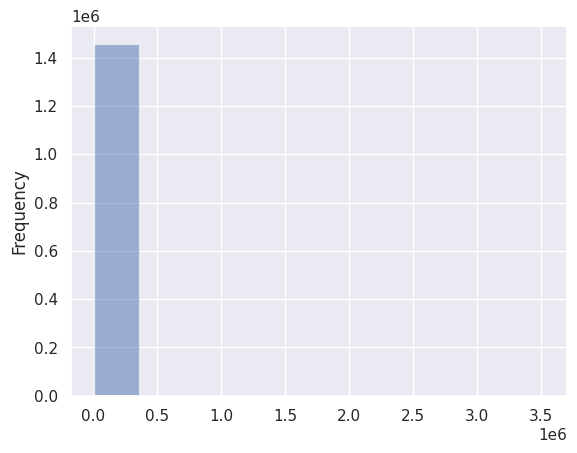

In [6]:
data['trip_duration'].plot.hist(alpha=0.5)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642


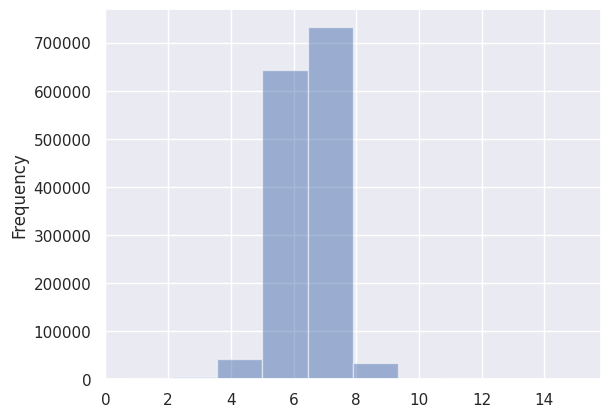

In [7]:
data['log_trip_duration']= np.log1p(data['trip_duration'])
data['log_trip_duration'].plot.hist(alpha=0.5)
# data.drop(['trip_duration'], axis=1, inplace=True)
data.head()

##0.1. MSE

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
X = data.drop(['log_trip_duration'], axis=1)
y = data['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from sklearn.dummy import DummyRegressor
dc_mf = DummyRegressor(strategy="mean") 
dc_mf.fit(X_train, y_train) 

y_train_pred = dc_mf.predict(X_train)
y_test_pred = dc_mf.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))
# dc_mf.score(X_test, y_test)

MSE train: 0.635, test: 0.629


## Часть 1. Изучаем `pickup_datetime`

**Задание 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [8]:
plt.figure(figsize=(250,50))
data['pickup_date'] = data['pickup_datetime'].apply(lambda x: x.date()) 
sns.countplot(x=data['pickup_date'].sort_values())
plt.xlabel('Day of year')
plt.ylabel('Number of trips')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [9]:
import calendar

pickup_df = pd.DataFrame()
pickup_df['pickup_datetime'] = data['pickup_datetime'].copy()
pickup_df['pickup_hour'] = pickup_df['pickup_datetime'].apply(lambda x: x.hour)
pickup_df['weekday_number'] = pickup_df['pickup_datetime'].apply(lambda x: x.weekday())
pickup_df['weekday'] = pickup_df['weekday_number'].apply(lambda x: calendar.day_name[x])
pickup_df['month_number'] = pickup_df['pickup_datetime'].apply(lambda x: x.month)
pickup_df['month'] = pickup_df['month_number'].apply(lambda x: calendar.month_name[x])
pickup_df

,pickup_datetime,pickup_hour,weekday_number,weekday,month_number,month
0,2016-03-14 17:24:55,17,0,Monday,3,March
1,2016-06-12 00:43:35,0,6,Sunday,6,June
2,2016-01-19 11:35:24,11,1,Tuesday,1,January
3,2016-04-06 19:32:31,19,2,Wednesday,4,April
4,2016-03-26 13:30:55,13,5,Saturday,3,March
...,...,...,...,...,...,...
1458639,2016-04-08 13:31:04,13,4,Friday,4,April
1458640,2016-01-10 07:35:15,7,6,Sunday,1,January
1458641,2016-04-22 06:57:41,6,4,Friday,4,April
1458642,2016-01-05 15:56:26,15,1,Tuesday,1,January


<Figure size 640x480 with 0 Axes>

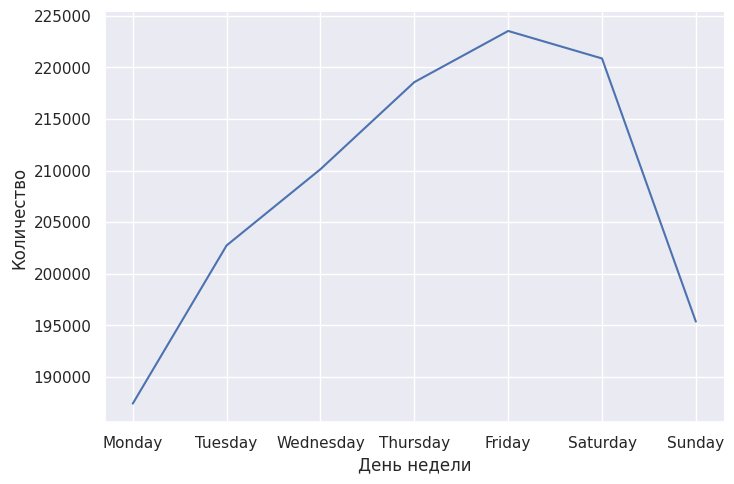

In [10]:
plt.figure()
pickup_weekday = pickup_df.sort_values(by=['weekday_number'])['weekday']
weekday_count = pickup_weekday.value_counts()[pickup_weekday.unique()]

x_weekplot = weekday_count.index.tolist()
y_weekplot = weekday_count.tolist()
weekplot = sns.relplot(x=x_weekplot, y= y_weekplot,
                       kind='line', height=5, aspect=1.5)
weekplot.set_xlabels('День недели')
weekplot.set_ylabels('Количество')

<Figure size 640x480 with 0 Axes>

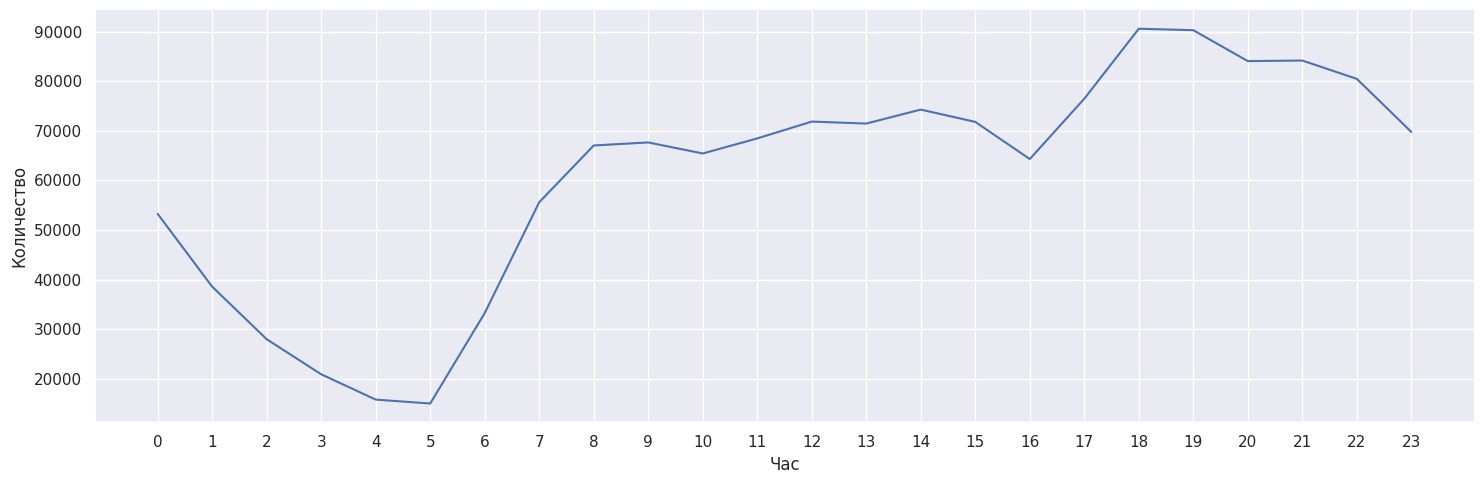

In [11]:
plt.figure()
hour_count = pickup_df['pickup_hour'].value_counts().sort_index()

x_hourplot = hour_count.index.tolist()
y_hourplot = hour_count.tolist()
hourplot = sns.relplot(x=x_hourplot, y= y_hourplot,
                       kind='line', height=5, aspect=3)
hourplot.set_xlabels('Час')
plt.xticks(range(24))
hourplot.set_ylabels('Количество')

**Задание 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

<Figure size 640x480 with 0 Axes>

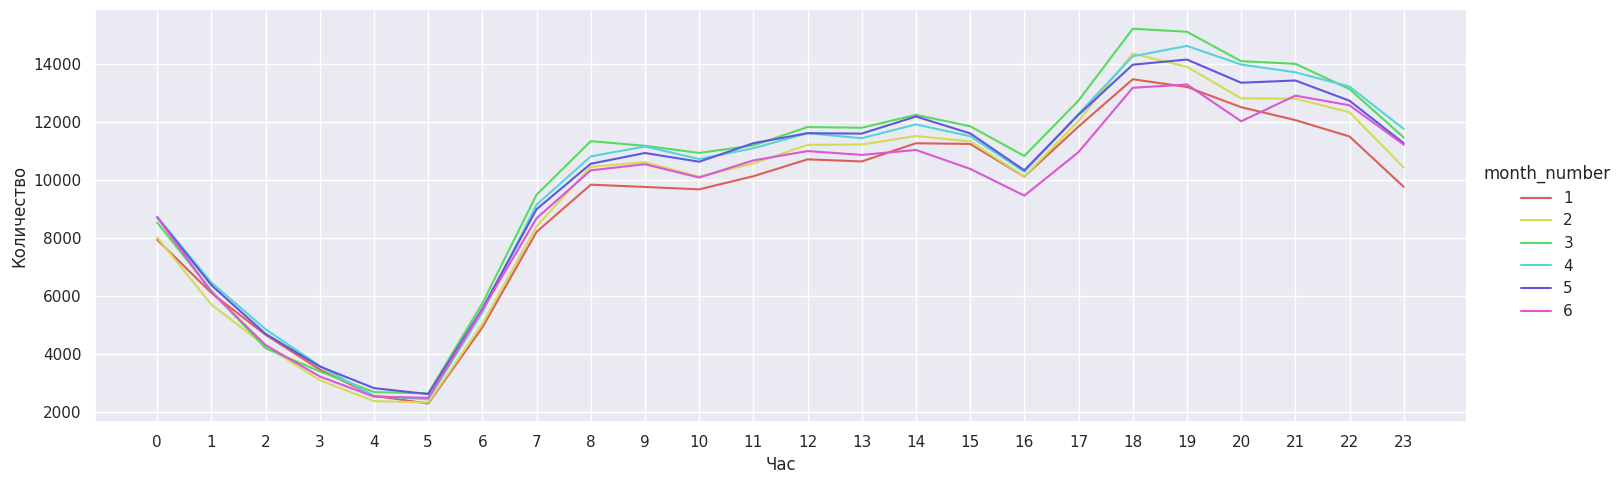

In [12]:
plt.figure()

unq = pickup_df.groupby(['month_number', 'pickup_hour']).nunique()
palette = sns.color_palette("hls", 6)
hourplot = sns.relplot(x='pickup_hour', y= 'pickup_datetime', data=unq,
                       kind='line', hue='month_number', palette=palette,
                       height=5, aspect=3)
hourplot.set_xlabels('Час')
plt.xticks(range(24))
hourplot.set_ylabels('Количество')

<Figure size 640x480 with 0 Axes>

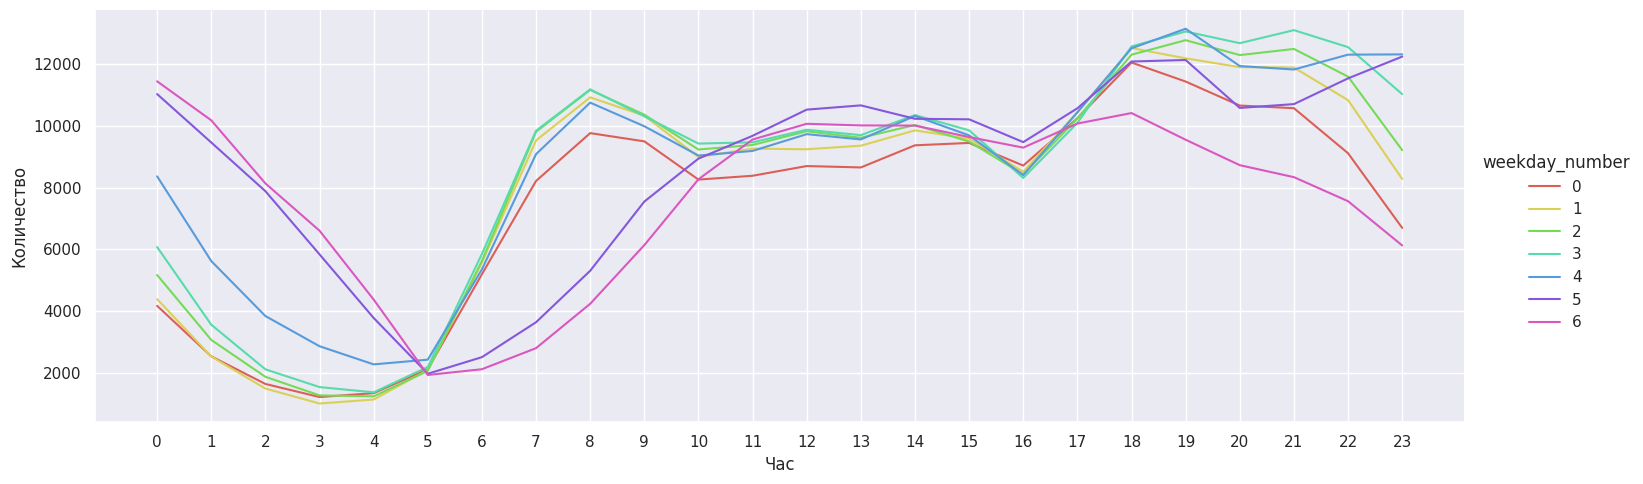

In [13]:
plt.figure()

unq = pickup_df.groupby(['weekday_number', 'pickup_hour']).nunique()
palette = sns.color_palette("hls", 7)
hourplot = sns.relplot(x='pickup_hour', y= 'pickup_datetime', data=unq,
                       kind='line', hue='weekday_number', palette=palette,
                       height=5, aspect=3)
hourplot.set_xlabels('Час')
plt.xticks(range(24))
hourplot.set_ylabels('Количество')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году


In [14]:
from datetime import date
data = data.merge(pickup_df.drop(['pickup_datetime'], axis=1), right_index=True, left_index=True)
data['is_blizzard'] = [1 if i==date(2016, 1, 23) else 0
                       for i in data['pickup_date']]
data['is_delay'] = [1 if i==date(2016, 5, 30) else 0
                       for i in data['pickup_date']]
data['day_of_year'] = pickup_df['pickup_datetime'].apply(lambda x: int(x.strftime("%j")))
data.drop(['pickup_date'], axis=1, inplace=True)
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_hour,weekday_number,weekday,month_number,month,is_blizzard,is_delay,day_of_year
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,17,0,Monday,3,March,0,0,74
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,0,6,Sunday,6,June,0,0,164
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,11,1,Tuesday,1,January,0,0,19
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,19,2,Wednesday,4,April,0,0,97
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,13,5,Saturday,3,March,0,0,86


**Задание 4**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [15]:
train, test = train_test_split(data, test_size=0.3)

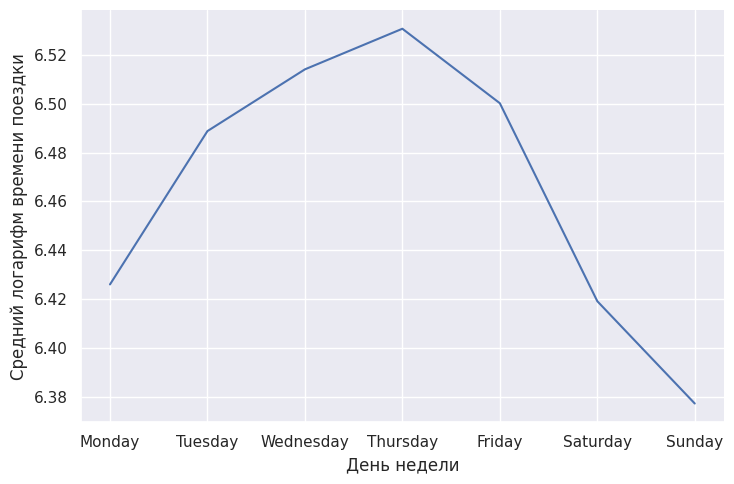

In [16]:
meanlog = train.groupby(['weekday_number', 'weekday'])['log_trip_duration'].mean()
x_meanlog = [x[1] for x in meanlog.index.tolist()]
y_meanlog = meanlog.tolist()
weekplot = sns.relplot(x=x_meanlog, y=y_meanlog,
                       kind='line', height=5, aspect=1.5)
weekplot.set_xlabels('День недели')
weekplot.set_ylabels('Средний логарифм времени поездки')

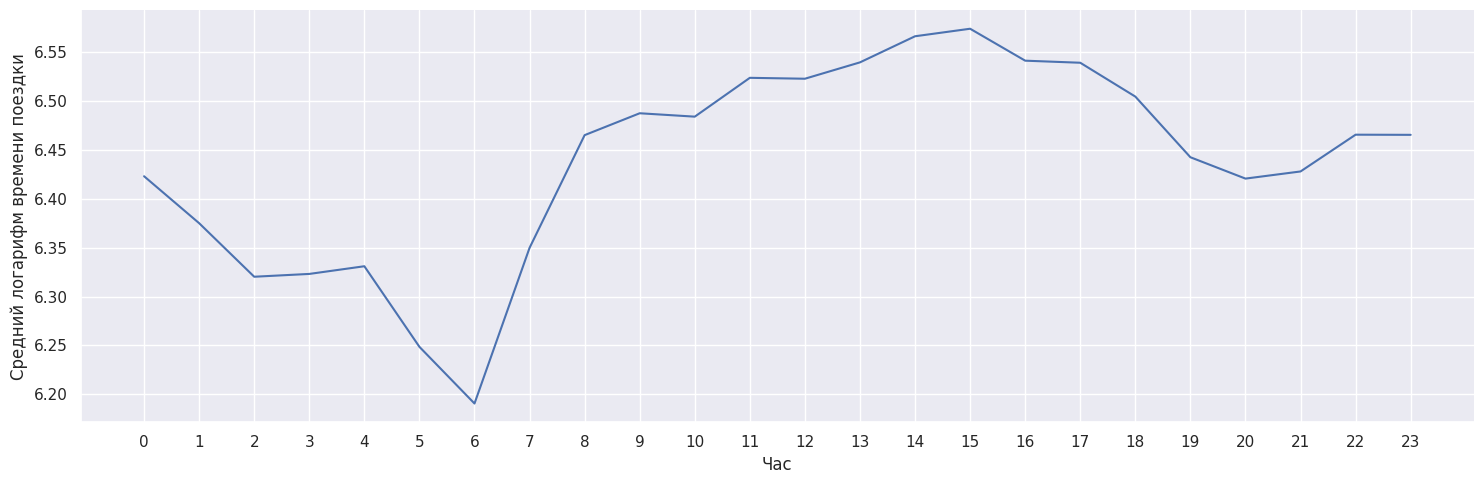

In [17]:
meanlog = train.groupby(['pickup_hour'])['log_trip_duration'].mean()
x_meanlog = meanlog.index.tolist()
y_meanlog = meanlog.tolist()
weekplot = sns.relplot(x=x_meanlog, y=y_meanlog,
                       kind='line', height=5, aspect=3)
weekplot.set_xlabels('Час')
plt.xticks(range(24))
weekplot.set_ylabels('Средний логарифм времени поездки')

In [18]:
meanlog = train.groupby(['day_of_year'])['log_trip_duration'].mean()
x_meanlog = meanlog.index.tolist()
y_meanlog = meanlog.tolist()
weekplot = sns.relplot(x=x_meanlog, y=y_meanlog,
                       kind='line', height=40, aspect=5)
weekplot.set_xlabels('День')
ticks = range(train['day_of_year'].min(), train['day_of_year'].max() + 1)
plt.xticks(ticks)
weekplot.set_ylabels('Средний логарифм времени поездки')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

In [19]:
data.drop(['month', 'weekday'], axis=1, inplace=True)
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_hour,weekday_number,month_number,is_blizzard,is_delay,day_of_year
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,17,0,3,0,0,74
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,0,6,6,0,0,164
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,11,1,1,0,0,19
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,19,2,4,0,0,97
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,13,5,3,0,0,86


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

##1.1. MSE

Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
X = data[['day_of_year', 'pickup_hour', 'weekday_number', 'month_number',
          'is_blizzard', 'is_delay']]
y = data['log_trip_duration']
enc = OneHotEncoder(handle_unknown='ignore')
X_transform = pd.DataFrame(enc.fit_transform(X).toarray())
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, random_state=0)
clf = Ridge(random_state=0)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))

MSE train: 0.622, test: 0.616


## Часть 2. Изучаем координаты 
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [20]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [21]:
show_circles_on_map(data.sample(100), "pickup_latitude", "pickup_longitude", "blue")

In [22]:
show_circles_on_map(data.sample(100), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [23]:
!pip install haversine
from haversine import haversine
pickup_longitude = data['pickup_longitude'].to_numpy()
pickup_latitude = data['pickup_latitude'].to_numpy()
dropoff_longitude = data['dropoff_longitude'].to_numpy()
dropoff_latitude = data['dropoff_latitude'].to_numpy()
distance = []
for start_x, start_y, end_x, end_y in zip(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
  distance.append(haversine((start_y, start_x),(end_y, end_x)))
data['haversine'] = distance
data.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_hour,weekday_number,month_number,is_blizzard,is_delay,day_of_year,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,17,0,3,0,0,74,1.498523
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,0,6,6,0,0,164,1.805510
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,11,1,1,0,0,19,6.385107
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,19,2,4,0,0,97,1.485500
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,13,5,3,0,0,86,1.188590


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [24]:
data['log_haversine']= np.log1p(data['haversine'])
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_hour,weekday_number,month_number,is_blizzard,is_delay,day_of_year,haversine,log_haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,17,0,3,0,0,74,1.498523,0.915700
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,0,6,6,0,0,164,1.805510,1.031585
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,11,1,1,0,0,19,6.385107,1.999465
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,19,2,4,0,0,97,1.485500,0.910474
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,13,5,3,0,0,86,1.188590,0.783258


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [25]:
print(f"Корелляция с расстоянием: {data['log_trip_duration'].corr(data['haversine'])}")
print(f"Корелляция с логарифмом расстояния: {data['log_trip_duration'].corr(data['log_haversine'])}")

Корелляция с расстоянием: 0.5735948311180152
Корелляция с логарифмом расстояния: 0.749882262889778


**Задание 7**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<Axes: ylabel='Frequency'>

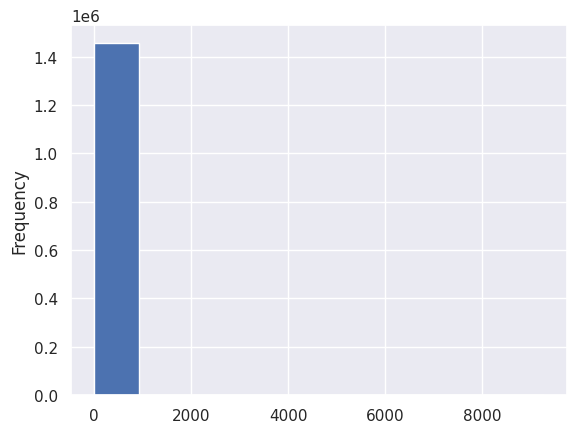

In [26]:
data['speed'] = data['haversine'] * 3600 / data['trip_duration']
data['speed'].plot.hist(alpha=1)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<Axes: ylabel='Frequency'>

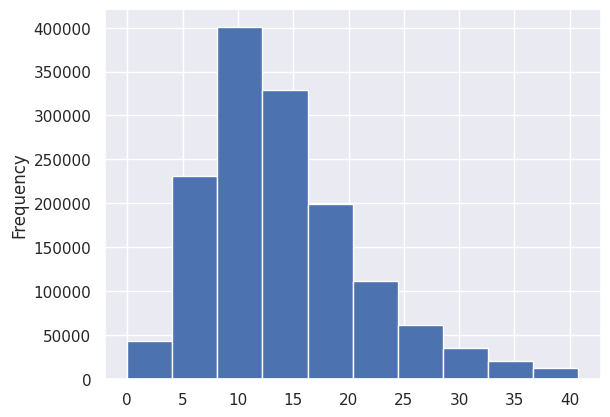

In [27]:
quantile_99 = data['speed'].quantile(0.99)
normal_speed = data[data['speed'] <= quantile_99]['speed'].copy()
normal_speed.plot.hist(alpha=1)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

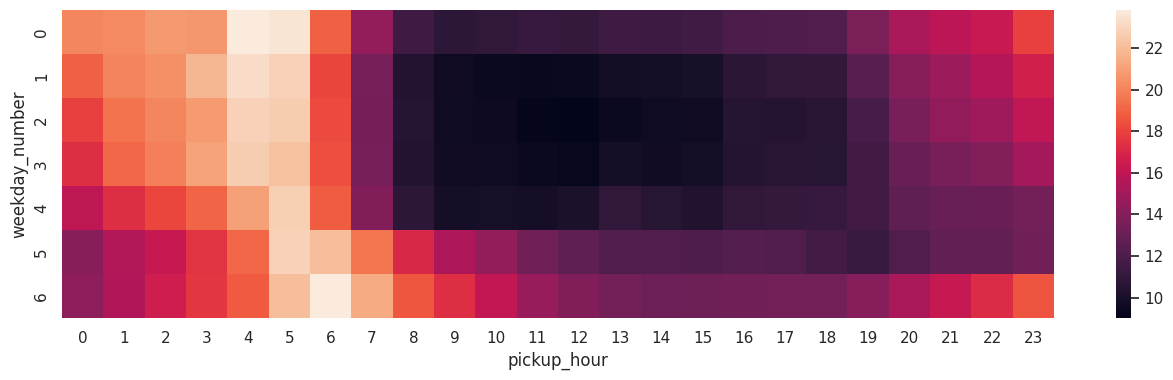

In [28]:
m = data.groupby(['weekday_number', 'pickup_hour'])['speed'].apply(np.median)
m.name = 'speed'
m.head()
plt.figure(figsize=(16,4))
m_heat = m.reset_index().pivot(columns='pickup_hour',
                               index='weekday_number',
                               values='speed',)
sns.heatmap(m_heat)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [29]:
data.drop(['speed'], axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [30]:
data['traffic_jam'] = [1 if day in range(5) and hour in range(8,20) else 0
                       for day, hour in 
                       zip(data['weekday_number'], data['pickup_hour'])]
data['free_road'] = [1 if (day in range(5) and hour in range(1,6))
                     or (day in range(5,7) and hour in range(4,8)) else 0
                     for day, hour in zip(data['weekday_number'], data['pickup_hour'])]                       
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pickup_hour,weekday_number,month_number,is_blizzard,is_delay,day_of_year,haversine,log_haversine,traffic_jam,free_road
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,17,0,3,0,0,74,1.498523,0.915700,1,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,0,6,6,0,0,164,1.805510,1.031585,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,11,1,1,0,0,19,6.385107,1.999465,1,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,19,2,4,0,0,97,1.485500,0.910474,1,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,13,5,3,0,0,86,1.188590,0.783258,0,0


**Задание 8**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [31]:
outline_points = [(40.6413111, -73.7803278), (40.6895314,  -74.1744624)]

def in_radius(point, center):
    return haversine(point, center) <= 0.5

data['pickup_kennedy'] = data.apply(lambda row:
                                         int(in_radius((row.pickup_latitude, row.pickup_longitude),
                                                       outline_points[0])), axis=1)
data['dropoff_kennedy'] = data.apply(lambda row:
                                         int(in_radius((row.dropoff_latitude, row.dropoff_longitude),
                                                       outline_points[0])), axis=1)
data['pickup_newark'] = data.apply(lambda row:
                                         int(in_radius((row.pickup_latitude, row.pickup_longitude),
                                                       outline_points[1])), axis=1)
data['dropoff_newark'] = data.apply(lambda row:
                                         int(in_radius((row.dropoff_latitude, row.dropoff_longitude),
                                                       outline_points[1])), axis=1)
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,is_delay,day_of_year,haversine,log_haversine,traffic_jam,free_road,pickup_kennedy,dropoff_kennedy,pickup_newark,dropoff_newark
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,0,74,1.498523,0.915700,1,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,0,164,1.805510,1.031585,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,0,19,6.385107,1.999465,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,0,97,1.485500,0.910474,1,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,0,86,1.188590,0.783258,0,0,0,0,0,0


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

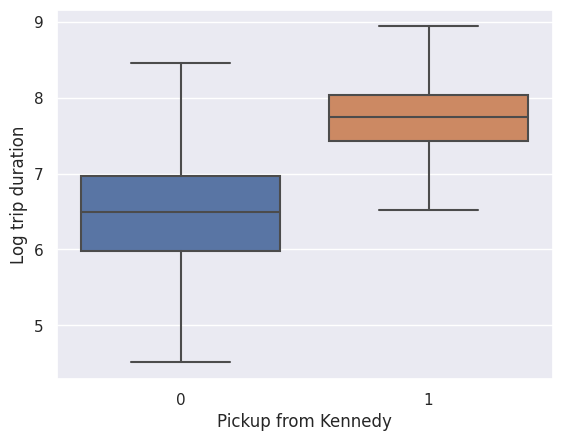

In [32]:
sns.boxplot(x='pickup_kennedy', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Pickup from Kennedy')
plt.ylabel('Log trip duration')
plt.show()

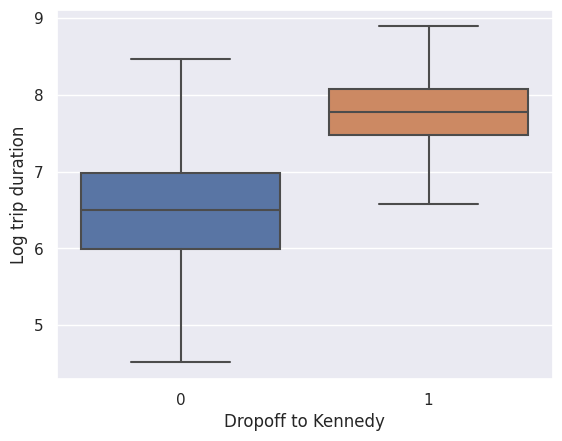

In [33]:
sns.boxplot(x='dropoff_kennedy', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Dropoff to Kennedy')
plt.ylabel('Log trip duration')
plt.show()

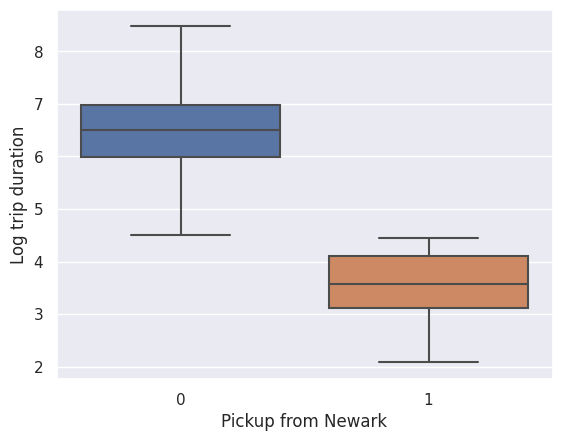

In [34]:
sns.boxplot(x='pickup_newark', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Pickup from Newark')
plt.ylabel('Log trip duration')
plt.show()

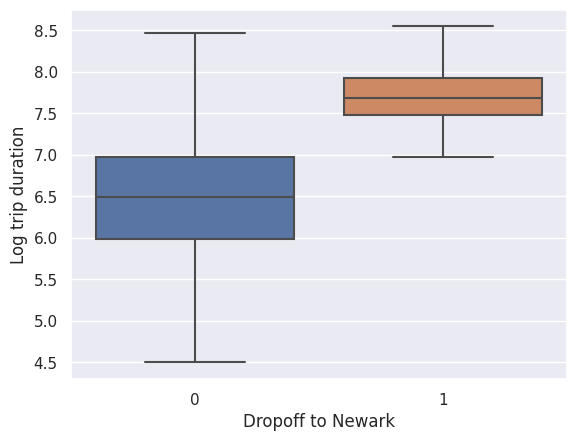

In [35]:
sns.boxplot(x='dropoff_newark', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Dropoff to Newark')
plt.ylabel('Log trip duration')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rows=4, cols=3):
        self.rows = rows
        self.cols = cols
        self.max_lat = None
        self.max_lon = None
        self.min_lat = None
        self.min_lon = None
    
    def show_grid(self, X):
        up_right = (self.max_lat, self.min_lon)
        down_right = (self.min_lat, self.min_lon)
        up_left = (self.max_lat, self.max_lon)      
        down_left = (self.min_lat, self.max_lon)

        location = (X['pickup_latitude'].mean(), X['pickup_longitude'].mean())
        
        m = folium.Map(location=location)
        for row in range(self.rows + 1):
            latitude = self.min_lat + self.cell_height * row 
            left = (latitude, self.min_lon)
            right = (latitude, self.max_lon)
            folium.PolyLine((left, right), color="red",
                            weight=2.5, opacity=1).add_to(m)

        for col in range(self.cols + 1):
            longtitude = self.min_lon + self.cell_width * col 
            up = (self.max_lat, longtitude)
            down = (self.min_lat, longtitude)
            folium.PolyLine((up, down), color="red",
                            weight=2.5, opacity=1).add_to(m)

        for _, row in X.iterrows():
          folium.Circle(
              radius=100,
              location=(row['pickup_latitude'], row['pickup_longitude']),
              color='blue',
              fill_color='blue',
              fill=True
          ).add_to(m)

        return m
    
    def fit(self, X, y=None):
        mean_lat = X.pickup_latitude.mean()
        mean_lon = X.pickup_longitude.mean()
        self.max_lat = mean_lat + 0.045
        self.max_lon = mean_lon + 0.045
        self.min_lat = mean_lat - 0.045
        self.min_lon = mean_lon - 0.045

        self.cell_width = (self.max_lon - self.min_lon) / self.cols
        self.cell_height = (self.max_lat - self.min_lat) / self.rows
        
    def transform(self, X, y=None):
        data = X.copy()
        cells = {}
        cell_number = 0
        for row in range(self.rows):
          cells[row] = []
          for col in range(self.cols):
            cells[row].append(cell_number)
            cell_number += 1
        pickup_cell_x = ((data.pickup_longitude - self.min_lon) / self.cell_width).astype(int)
        pickup_cell_y = ((data.pickup_latitude - self.min_lat) / self.cell_height).astype(int)
        dropoff_cell_x = ((data.dropoff_longitude - self.min_lon) / self.cell_width).astype(int)
        dropoff_cell_y = ((data.dropoff_latitude - self.min_lat) / self.cell_height).astype(int)

        pickup_cell = pickup_cell_y * self.rows + pickup_cell_x
        dropoff_cell = dropoff_cell_y * self.rows + dropoff_cell_x

        pickup_cell[(pickup_cell_x < 0) | (pickup_cell_x >= self.rows) |
                    (pickup_cell_y < 0) | (pickup_cell_y >= self.cols)] = -1
        dropoff_cell[(dropoff_cell_x < 0) | (dropoff_cell_x >= self.rows) |
                     (dropoff_cell_y < 0) | (dropoff_cell_y >= self.cols)] = -1
        data['pickup_cell'] = pickup_cell
        data['dropoff_cell'] = dropoff_cell
        return data

In [37]:
transformer = MapGridTransformer(rows=4, cols=3)
transformer.fit(data)
data = transformer.transform(data)
transformer.show_grid(data.sample(100))

##2.1. MSE

Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
categorial_clms = data[['pickup_hour', 'weekday_number', 'month_number',
                        'pickup_cell', 'dropoff_cell']]

binary_clms = data[['traffic_jam', 'free_road', 'pickup_kennedy',
                    'dropoff_kennedy', 'pickup_newark', 'dropoff_newark']]

numerical_clms = data[['log_haversine']]

y = data['log_trip_duration']

enc = OneHotEncoder(handle_unknown='ignore')
cat_transform = pd.DataFrame(enc.fit_transform(categorial_clms).toarray())
cat_transform.columns = enc.get_feature_names_out()

scaler = StandardScaler()
num_transform = pd.DataFrame(scaler.fit_transform(numerical_clms),
                             columns=numerical_clms.columns)


X = pd.concat((cat_transform, num_transform, binary_clms), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = Ridge(random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))

MSE train: 0.231, test: 0.228


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [38]:
# Считаем количество уникальных значений в признаке vendor_id
print("Unique vendor_id:", data['vendor_id'].nunique())

# Считаем количество уникальных значений в признаке passenger_count
print("Unique passenger_count:", data['passenger_count'].nunique())

# Считаем количество уникальных значений в признаке store_and_fwd_flag
print("Unique store_and_fwd_flag:", data['store_and_fwd_flag'].nunique())

Unique vendor_id: 2
Unique passenger_count: 10
Unique store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

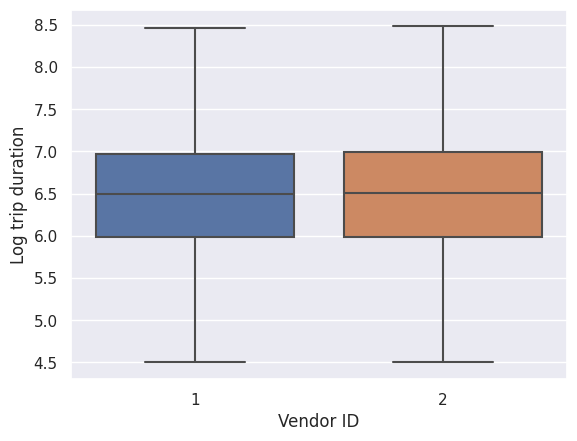

In [39]:
sns.boxplot(x='vendor_id', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Vendor ID')
plt.ylabel('Log trip duration')
plt.show()

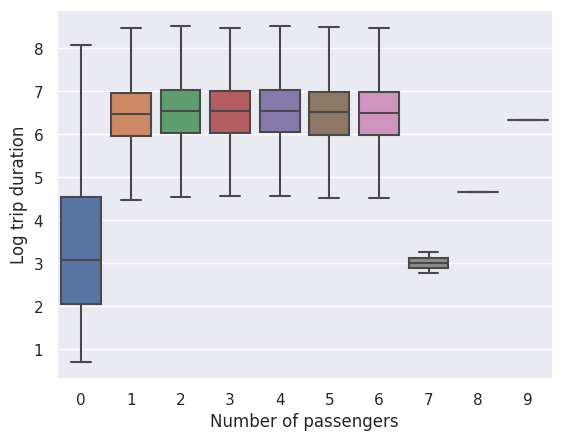

In [40]:
sns.boxplot(x='passenger_count', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Number of passengers')
plt.ylabel('Log trip duration')
plt.show()

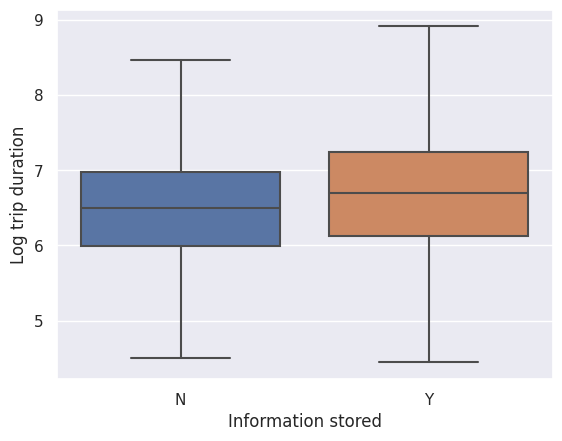

In [41]:
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration',
            data=data, showfliers=False)
plt.xlabel('Information stored')
plt.ylabel('Log trip duration')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [42]:
data['vendor_id'] = data['vendor_id'].map({1: 0, 2: 1})
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

In [43]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_hour,...,haversine,log_haversine,traffic_jam,free_road,pickup_kennedy,dropoff_kennedy,pickup_newark,dropoff_newark,pickup_cell,dropoff_cell
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,...,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,5.349503e-01,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,9.594923e+02,6.466978e+00,1.360648e+01,...,3.440869e+00,1.254587e+00,4.401307e-01,5.410025e-02,6.665780e-03,2.510551e-03,1.919591e-05,4.565884e-04,4.216913e+00,3.949071e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,5.237432e+03,7.957595e-01,6.399693e+00,...,4.296544e+00,6.271531e-01,4.964029e-01,2.262155e-01,8.137169e-02,5.004248e-02,4.381273e-03,2.136306e-02,4.053429e+00,4.121949e+00
min,0.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,1.000000e+00,6.931472e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,3.970000e+02,5.986452e+00,9.000000e+00,...,1.231838e+00,8.028256e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
50%,1.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,6.620000e+02,6.496775e+00,1.400000e+01,...,2.093720e+00,1.129374e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00
75%,1.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,0.000000e+00,1.075000e+03,6.981006e+00,1.900000e+01,...,3.875343e+00,1.584190e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,9.000000e+00
max,1.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,3.526282e+06,1.507575e+01,2.300000e+01,...,1.240910e+03,7.124406e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01,1.100000e+01


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

##3.1. MSE

Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
categorial_clms = data[['pickup_hour', 'weekday_number', 'month_number',
                        'pickup_cell', 'dropoff_cell']]

binary_clms = data[['traffic_jam', 'free_road', 'pickup_kennedy',
                    'dropoff_kennedy', 'pickup_newark', 'dropoff_newark',
                    'vendor_id', 'store_and_fwd_flag']]

numerical_clms = data[['log_haversine', 'passenger_count']]

y = data['log_trip_duration']

enc = OneHotEncoder(handle_unknown='ignore')
cat_transform = pd.DataFrame(enc.fit_transform(categorial_clms).toarray())
cat_transform.columns = enc.get_feature_names_out()

scaler = StandardScaler()
num_transform = pd.DataFrame(scaler.fit_transform(numerical_clms),
                             columns=numerical_clms.columns)


X = pd.concat((cat_transform, num_transform, binary_clms), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = Ridge(random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))

MSE train: 0.231, test: 0.228


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [ ]:
data.drop(['passenger_count', 'vendor_id', 'store_and_fwd_flag'],
          axis=1, inplace=True)

## Часть 4. Улучшаем модель

**Задание 13**. Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [44]:
counts = data['day_of_year'].value_counts()
rare_categories = counts[counts < 10000].index.tolist()
data['day_of_year'] = data['day_of_year'].apply(lambda x: 'Other' if x in rare_categories else x)
data['day_of_year'].unique()

array(['Other'], dtype=object)

В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [45]:
data_train, data_test = train_test_split(data, random_state=0)

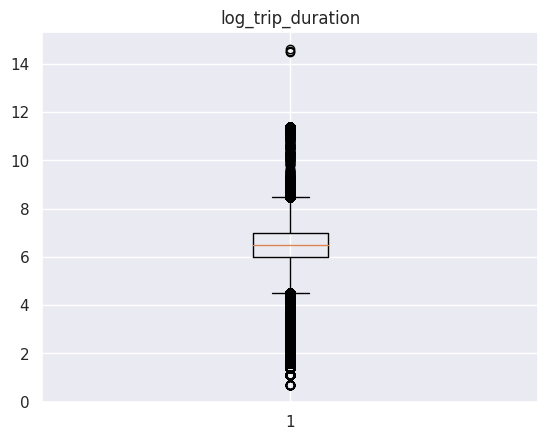

In [46]:
plt.boxplot(data_train['log_trip_duration'])
plt.title('log_trip_duration')
plt.show()

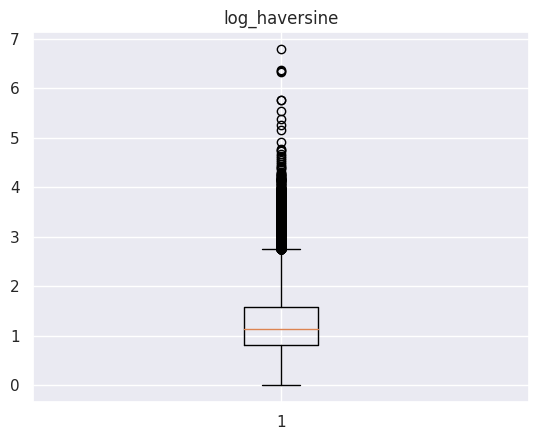

In [47]:
plt.boxplot(data_train['log_haversine'])
plt.title('log_haversine')
plt.show()

In [48]:
dur_lower_bound = data_train['log_trip_duration'].mean() - 3 * data_train['log_trip_duration'].std()
dur_upper_bound = data_train['log_trip_duration'].mean() + 3 * data_train['log_trip_duration'].std()
hav_upper_bound = data_train['log_haversine'].mean() + 3 * data_train['log_haversine'].std()

In [49]:
data_train = data_train[(data_train['log_trip_duration'] >= dur_lower_bound) &
                        (data_train['log_trip_duration'] <= dur_upper_bound)]
data_train = data_train[data_train['log_haversine'] <= hav_upper_bound]

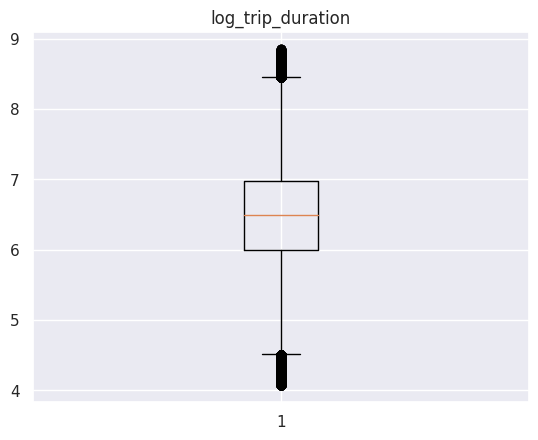

In [50]:
plt.boxplot(data_train['log_trip_duration'])
plt.title('log_trip_duration')
plt.show()

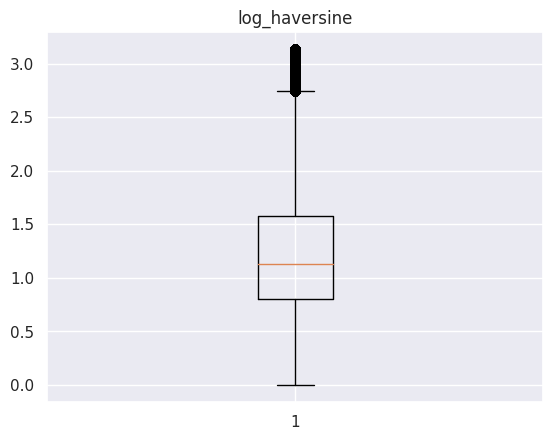

In [51]:
plt.boxplot(data_train['log_haversine'])
plt.title('log_haversine')
plt.show()

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [52]:
categorial_clms = ['pickup_hour', 'weekday_number', 
                   'month_number', 'pickup_cell', 'dropoff_cell']

binary_clms = ['traffic_jam', 'free_road', 'pickup_kennedy', 
               'dropoff_kennedy', 'pickup_newark', 'dropoff_newark']

numerical_clms = ['log_haversine']

y_train = data_train['log_trip_duration']
y_test = data_test['log_trip_duration']


enc = OneHotEncoder(handle_unknown='ignore')

cat_train = pd.DataFrame(enc.fit_transform(data_train[categorial_clms]).toarray(),
                         index=data_train.index)
cat_train.columns = enc.get_feature_names_out()

cat_test = pd.DataFrame(enc.fit_transform(data_test[categorial_clms]).toarray(),
                        index=data_test.index)
cat_test.columns = enc.get_feature_names_out()


scaler = StandardScaler()

num_train = pd.DataFrame(scaler.fit_transform(data_train[numerical_clms]),
                         index=data_train.index, 
                         columns=data_train[numerical_clms].columns)

num_test = pd.DataFrame(scaler.fit_transform(data_test[numerical_clms]),
                        index=data_test.index, 
                        columns=data_test[numerical_clms].columns)


X_train = pd.concat((cat_train, num_train, data_train[binary_clms]), axis=1)

X_test = pd.concat((cat_test, num_test, data_test[binary_clms]), axis=1)

clf = Ridge(random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))

MSE train: 0.168, test: 0.229


**Задание 14**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [53]:
print("Количество признаков до кодирования:", len(categorial_clms))
print("Количество признаков после кодирования:",
      len(enc.get_feature_names_out()))

Количество признаков до кодирования: 5
Количество признаков после кодирования: 63


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [54]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0)
lasso.fit(X_train, y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train,
                                                          y_train_pred_lasso),
                mean_squared_error(y_test,
                                   y_test_pred_lasso)))

MSE train: 0.525, test: 0.629


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [56]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}


lasso = Lasso(random_state=0)

lasso_grid = GridSearchCV(lasso, params, cv=3, scoring='neg_mean_squared_error')
lasso_grid.fit(X_val, y_val)
print(f'Лучший параметр alpha Lasso: {lasso_grid.best_params_["alpha"]}')


ridge = Ridge(random_state=0)

ridge_grid = GridSearchCV(ridge, params, cv=3, scoring='neg_mean_squared_error')
ridge_grid.fit(X_val, y_val)
print(f'Лучший параметр alpha Ridge: {ridge_grid.best_params_["alpha"]}')

Лучший параметр alpha Lasso: 0.001
Лучший параметр alpha Ridge: 0.001


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

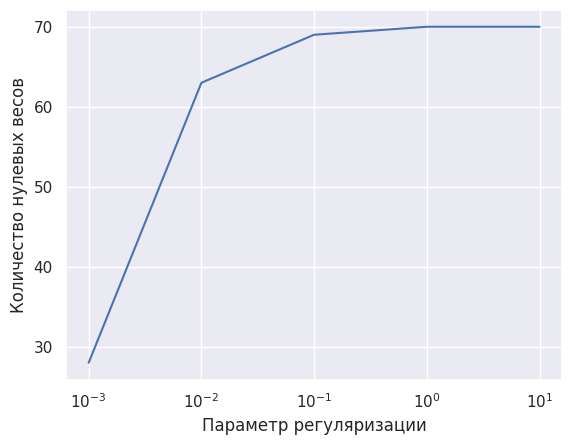

In [57]:
zero_coeffs = []
for alpha in params['alpha']:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_val, y_val)
    zero_coeffs.append(np.sum(lasso.coef_ == 0))
plt.plot(params['alpha'], zero_coeffs)
plt.xscale('log')
plt.xlabel('Параметр регуляризации')
plt.ylabel('Количество нулевых весов')
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [58]:
data['pickup_dropoff_cells'] = [f'{start}_{end}' for start, end in
                                zip(data['pickup_cell'], data['dropoff_cell'])]
rare = data['pickup_dropoff_cells'].value_counts().index[50:]                                
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,log_haversine,traffic_jam,free_road,pickup_kennedy,dropoff_kennedy,pickup_newark,dropoff_newark,pickup_cell,dropoff_cell,pickup_dropoff_cells
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455,...,0.915700,1,0,0,0,0,0,9,9,9_9
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663,...,1.031585,0,0,0,0,0,0,5,4,5_4
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,...,1.999465,1,0,0,0,0,0,9,0,9_0
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429,...,0.910474,1,0,0,0,0,0,0,0,0_0
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435,...,0.783258,0,0,0,0,0,0,-1,-1,-1_-1


In [59]:
data_train['pickup_dropoff_cells'] = [f'{start}_{end}' for start, end in
                                zip(data_train['pickup_cell'], data_train['dropoff_cell'])]
data_test['pickup_dropoff_cells'] = [f'{start}_{end}' for start, end in
                                zip(data_test['pickup_cell'], data_test['dropoff_cell'])]                                
data_train['pickup_dropoff_cells'] = data_train['pickup_dropoff_cells'].apply(lambda x: 'Other' if x in rare else x)
data_test['pickup_dropoff_cells'] = data_test['pickup_dropoff_cells'].apply(lambda x: 'Other' if x in rare else x)
data_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,log_haversine,traffic_jam,free_road,pickup_kennedy,dropoff_kennedy,pickup_newark,dropoff_newark,pickup_cell,dropoff_cell,pickup_dropoff_cells
769896,id2552863,1,2016-02-03 18:56:43,5,-73.988739,40.753479,-73.994049,40.734459,0,605,...,1.151120,1,0,0,0,0,0,8,4,8_4
562980,id0041360,1,2016-02-27 17:06:59,1,-73.996368,40.738106,-73.998428,40.745251,0,325,...,0.595101,0,0,0,0,0,0,4,4,4_4
364339,id0305532,1,2016-05-01 02:38:28,5,-74.008202,40.737961,-73.981270,40.748711,0,513,...,1.271025,0,0,0,0,0,0,4,5,4_5
44595,id1291569,1,2016-03-18 19:21:26,4,-73.955116,40.788883,-73.957031,40.775173,0,364,...,0.929400,1,0,0,0,0,0,-1,-1,-1_-1
815832,id0075916,1,2016-01-15 02:34:06,1,-73.990150,40.756649,-73.985573,40.763432,0,106,...,0.613574,0,1,0,0,0,0,8,9,8_9


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [60]:
categorial_clms = ['pickup_hour', 'weekday_number', 
                   'month_number', 'pickup_dropoff_cells']

binary_clms = ['traffic_jam', 'free_road', 'pickup_kennedy', 
               'dropoff_kennedy', 'pickup_newark', 'dropoff_newark']

numerical_clms = ['log_haversine']

y_train = data_train['log_trip_duration']
y_test = data_test['log_trip_duration']


enc = OneHotEncoder(handle_unknown='ignore')

cat_train = pd.DataFrame(enc.fit_transform(data_train[categorial_clms]).toarray(),
                         index=data_train.index)
cat_train.columns = enc.get_feature_names_out()

cat_test = pd.DataFrame(enc.fit_transform(data_test[categorial_clms]).toarray(),
                        index=data_test.index)
cat_test.columns = enc.get_feature_names_out()


scaler = StandardScaler()

num_train = pd.DataFrame(scaler.fit_transform(data_train[numerical_clms]),
                         index=data_train.index, 
                         columns=data_train[numerical_clms].columns)

num_test = pd.DataFrame(scaler.fit_transform(data_test[numerical_clms]),
                        index=data_test.index, 
                        columns=data_test[numerical_clms].columns)


X_train = pd.concat((cat_train, num_train, data_train[binary_clms]), axis=1)

X_test = pd.concat((cat_test, num_test, data_test[binary_clms]), axis=1)

clf = Ridge(random_state=0, alpha=0.001)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))

MSE train: 0.164, test: 0.225
